# Turkey

In [289]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

import numpy as np
import pandas as pd
from IPython.display import Image

## Question

### When cooking a 15 pound turkey, what is the best length of time to cook it for and best oven temperature to cook it at?

With the upcoming Thanksgiving season, the concern of cooking the perfect turkey is on many families’ minds.
If you cook a turkey at too high of an oven temperature, the outside cooks faster than the inside, and can cause burning or undercooking of the inside of the turkey. 

On the other hand, if you cook a turkey at too low an oven temperature, it takes a very long time to cook, and you do not get a good crispy outside. Also, if you cook a turkey for too little time you risk undercooking and if you cook a turkey for too long it can cause dryness and burning. It’s important to balance time and oven temperature in order to cook a good thanksgiving turkey, and so we explored the ideal factors.


## Model

We modeled the turkey as a sphere made of two layers. The spherical turkey weighed 15 lbs and has a diameter of 34 centimeters -- determined from the pan size listed in this turkey recipe: [https://blog.metrokitchen.com/roasting-pan-guide/]. The outer layer of the turkey was assumed to have a thickness of 2 cm to represent the skin and outer meat layer. The heat of the oven was kept constant within a single run of the simulation, and heat was modeled to be transferred via conduction between the air of the oven and the outer layer of the turkey, and between the outer and inner layers.

In [3]:
def make_system(params, T_oven, T_init, t_end):
    """Make a system object for the turkey model.
    inner is inner temperature of turkey
    outer is outer temperature of turkey
    
    params is the r and C values for thermal compartments
    t_end is when the turkey is taken out of the oven
    )
    
    returns: System object
    """
    #initial temperatures are of the temperature of pre-heated oven
    init = State(T_inner=T_init, T_outer=T_init)

    return System(init=init, t0=0, t_end=t_end, T_oven=T_oven,
                  params = params)

The C value of each layer was estimated as the mass multiplied by the specific heat of turkey meat (3.53 kJ/kg\*K) from this article https://www.researchgate.net/file.PostFileLoader.html?id=57dc0df6dc332d6c7a2b0e94&assetKey=AS%3A406964417908742%401474039286881 and the R values were estimated so the temperature of the internal layer over time would match that of an actual turkey being cooked in this paper: http://www.greenbuildingadvisor.com/sites/default/files/Modeling%20Heat%20Transfer%20of%20Turkeys.pdf

In [323]:
params = Params(
    r_inner = 0.0015, #Km^2/W
    r_outer = 0.012, #Km^2/W
    c_inner = 16490, #J/K
    c_outer = 7520); #J/K

The functions convert_k_to_f to assist in plot clarity. convert_k_to_f converts the kelvin temperatures from calculations into fahrenheit for plotting.

In [38]:
def convert_k_to_f(k):
    return (k-273)*(9/5) + 32

To calculate the temperature derivative with respect to time of the outer and inner layers (dodt and didt respectively), we used the formulas
Flux = (T_ext - T) / R
and
dT/dt = net flux/C
where R = thermal resistivity and C = thermal mass.

In [39]:
def slope_func(state, t, system):
    """Makes the differential equations.
    
    state: State (T_inner, T_outer)
    t: time
    system: System object
    
    returns: didt, dodt
    """
    
    unpack(system)
    r_outer, r_inner, c_inner, c_outer = params
    T_inner, T_outer = state
    
    o_flux = (T_oven-T_outer)/r_outer
    i_flux = (T_outer-T_inner)/r_inner
    
    dodt = (o_flux-i_flux)/c_outer
    didt = i_flux/c_inner
    
    return didt, dodt

Plot results is created to aid in plotting our model's inner and outer turkey temperature and data from an article (validation).

In [40]:
def plot_results_validation(inner, outer, validation):
    """Plot the inner and outer temperatures of the Turkey
    to compare to the validation curve
    
    inner: TimeSeries
    outer: TimeSeries
    validation: TimeSeries
    
    """
    inner_f=convert_k_to_f(inner)
    outer_f=convert_k_to_f(outer)
    validation_f=convert_k_to_f(validation)
    plot(inner_f, '-', label='Inner Temperature')
    plot(outer_f, '-', label='Outer Temperature')
    plot(validation_f, '-', label='Validation')
    
    decorate(xlabel='Time (Minutes)',
             ylabel='Temperature (Degrees F)',
             title = 'Cooking Time of a Turkey')

### Validation

To calibrate the r values and verify that the curve for turkey cooking is correct, the inner temperatures of the turkey over time are plotted and compared to the shape of the curve from this article: [http://www.greenbuildingadvisor.com/sites/default/files/Modeling%20Heat%20Transfer%20of%20Turkeys.pdf] and the final temperature inner temp at 3hrs 20 mins when the turkey should be cooked is compared to that of this recipe: [https://www.allrecipes.com/recipe/166160/juicy-thanksgiving-turkey/ ].

The plot below is from the article. Its data points were translated over manually to a TimeSeries to then be plotted as validation.

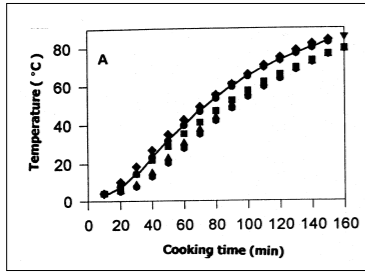

In [41]:
Image("images/turkey_temp_graph.png")

#### Legend: 

#### circle = thigh of 6.8kg calculated values from artile (best fit line matches to this)

#### hexagon = thigh of 7.1kg fresh turkey 

6.8kg is 15 pounds (the weight of our model's turkey). The graph from the article shows the curve for the inner temperature of a turkey (thigh in this case). The thigh was chosen to be a good proxy for inner turkey temperature due to the limited options in the article (which were wing joint, breast, thigh) and because the thigh is thick and close to the inside of the turkey.

The data points were found and written down manually into a TimeSeries, and then plotted as an individual graph to make sure it was an accurate representation of the article data.

In [42]:
t_validation = [10, 20, 40, 60, 80, 90, 95, 100, 120, 140, 160] #minutes
inner_T_valid_C = [1, 5, 20, 40, 55, 63, 66, 68, 75, 80, 85] #degrees celcius
data_validation_C = TimeSeries(inner_T_valid_C,t_validation);

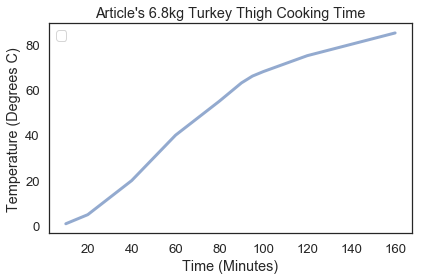

In [43]:
plot(data_validation_C)
decorate(xlabel='Time (Minutes)',
        ylabel='Temperature (Degrees C)',
        title = 'Article\'s 6.8kg Turkey Thigh Cooking Time')

The temperatures in the article, which were in celcius, were converted to kelvin to match with the units of our model temperatures.

In [44]:
inner_T_validation = []
for temp in inner_T_valid_C:
    temp_k = temp + 273
    inner_T_validation.append(temp_k)
data_validation = TimeSeries(inner_T_validation,t_validation);

The validation curve is then plotted with the model temperatures. The model temperatures are calculated using the params, make_system, and slope_func (shown above) and the ode_solver below.

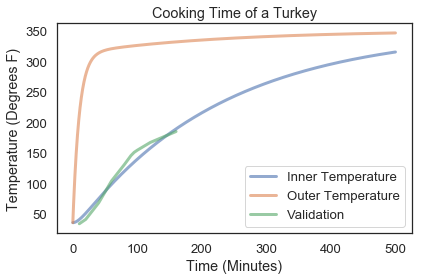

In [45]:
system = make_system(params,450,275,500) #params, T_oven, T_init, t_end
results, details = run_ode_solver(system,slope_func,max_step=1)
plot_results_validation(results.T_inner, results.T_outer, data_validation)

Then, for additional verification and to fine tune the r values, the recipe values were compared to our model's values. The recipe for a 15 pound turkey has the inner temperature of the turkey at 180 degrees fahrenheit when it is removed from the oven after 200 minutes (3 hrs 20 mins). For our verification plot, the inner temperature of the turkey is 180 degrees fahrenheit at 200 minutes.

### Sweep

Once the temperatures are verified on a graph, a SweepSeries of oven temperatures is made. sweep_temp takes in the minimum and maximum oven temperature, and the number of oven temperatures in order to create the sweeps. It then runs the ode_solver for each sweep and assigns a color for that sweep to be plotted as. Inner and outer temp have the same color for clarity. 

The sweepseries then plots a graph of several oven temperatures and their corresponding inner temperature and outer temperature of the turkey at given times.

In [46]:
def sweep_temp(slope_func, min_temp, max_temp, t, num_runs):
    '''Sweep oven temperature
    
    min_temp: lowest oven temperature 
    max_temp: highest oven temperature 
    t: time
    num_runs: number of oven temperatures
    
    Returns: Sweepseries
    '''
    
    temp_array = linspace(min_temp, max_temp, num_runs) #makes the array of oven temps
    sweep = SweepSeries()
    
    colors = ['red','orange','yellow','green','blue','purple'] #the different colors the temps can be plotted as
    color_counter = 0
    
    for temp in temp_array:
        system=make_system(params,temp,275,t) #make_system(params, T_oven, T_init, t_end)
        results, details = run_ode_solver(system,slope_func,max_step=1)
        
        plot_results(results.T_inner, results.T_outer, colors[color_counter])
        color_counter += 1
        if color_counter == 6: #max 6 color options, then resets
           color_counter = 0 
        
        sweep[temp] = results
    
    return sweep

plot_results takes in the color of each oven temperature and its turkey temperatures and plots the turkey temperatures with that color.

In [47]:
def plot_results(inner, outer, color):
    """Plot the inner and outer temperatures of the Turkey
    
    inner: TimeSeries
    outer: TimeSeries
    color: the color the temps will be plotted in
    
    """
    inner_f=convert_k_to_f(inner)
    outer_f=convert_k_to_f(outer)
    plot(inner_f, '-', color = color)
    plot(outer_f, '-', color = color)
    
    decorate(xlabel='Time (Minutes)',
             ylabel='Temperature(Degrees F)')

Shown here is a sweep of just 4 runs, the low number chosen for visual clarity, starting at 350 F (394 K) and ending at 450 F (500 K). The temperature bounds were chosen to be 100 degrees above and below the average oven temperature in turkey recipes, 350 degrees F. The lowest temperature is plotted in red, and then ascends through the rainbow color spectrum with higher temperatures.

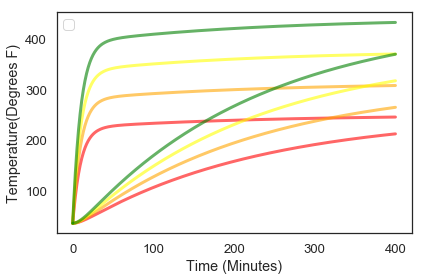

In [48]:
readable_sweep = sweep_temp(slope_func, 394, 500, 400, 4); #sweep_temp(slope_func, min_temp, max_temp, t, num_runs)

This sweep has more oven temperatures (15) to be more detailed. This sweep is plotted and then used below in results to create a clear table, showing the different values for inner and outer temp based on oven temp.

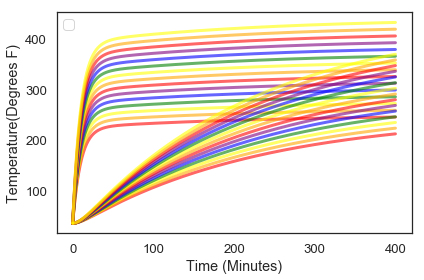

In [49]:
detailed_sweep = sweep_temp(slope_func, 394, 500, 400, 15); #sweep_temp(slope_func, min_temp, max_temp, t, num_runs)

## Results

To reveiw, our goal was to find the ideal oven temperature and cooking time to cook a turkey that will make the inner layer temperature be "done" at the same time as the outer layer temperature is "crispy". 

As was discussed in the validation section, the temperature of the inside of a turkey when it's cooked is 180 degrees F according to a well-reviewed online recipe. We made the assumption that the ideal temperature for the outer layer is as hot as possible, for maximum crispiness, as long as the skin does not burn. The outside of meat burns at 355 degrees F (https://modernistcuisine.com/2013/03/the-maillard-reaction/) so our target outside temperature was slightly below 355 degrees F.

To determine the temperature and time at which the inside is 180 degrees F and the outside is just under 355 degrees F, we first isolated the row within each run of the sweep where the inside is the closest to 180 degrees F. make_results_table displays the oven temperature, cook time, and outer temperature associated with each close-to-180 inner temperature.

In [50]:
def make_results_table(sweep, target_temp_k):
    
    '''Determine temperature of outer layer while inner layer 
    is at target temp for each oven temperature in sweep
    
    sweep: SweepSeries containing inner and outer layer temperatures where index is oven temperatures
    target_temp: desired temperature of inner layer, in kelvin
    
    Returns: DataFrame containing corresponding oven temperatures, cook time, inner temperatures (close
    to target temperature), and outer temperatures in fahrenheit'''
    
    #initialize temperature lists to be displayed in dataframe
    inner_list = pd.Series([])
    outer_list = pd.Series([])
    index_list = pd.Series([])
    
    #make list of outer temperature pairings with inner temperature closest to 180
    for oven_temp in sweep.index:
        #get inner temp closest to 180
        off_from_180_list=[]
        for temp in sweep[oven_temp].T_inner:
            off_from_180 = abs(target_temp_k - temp)
            if off_from_180 < 0.3:
                closest_temp = temp
                break
        
        #determine corresponding outer temp to ~180 inner temp
        for index in sweep[oven_temp].T_inner.index:
            if sweep[oven_temp].T_inner[index] == closest_temp:
                corresp_index = index
        corresp_outer = sweep[oven_temp].T_outer[corresp_index]
        
        #add found temperatures to lists
        inner_list = inner_list.append(pd.Series([closest_temp]))
        outer_list = outer_list.append(pd.Series([corresp_outer]))
        index_list = index_list.append(pd.Series([corresp_index]))
        
    #convert inner and outer temperature matches and oven temp to f and compile all into dataframe
    table_final = pd.DataFrame({'Oven Temperature (F)':convert_k_to_f(sweep.index),
                                'Time (min)':index_list,
                                'Inner Temperature (F)':convert_k_to_f(inner_list), 
                                'Outer Temperature (F)':convert_k_to_f(outer_list)})
    
    return table_final

In [51]:
results_table = make_results_table(detailed_sweep, 355)

,Oven Temperature (F),Time (min),Inner Temperature (F),Outer Temperature (F)
0,249.800000,259.205742,179.350217,241.605317
0,263.428571,233.203219,179.269901,253.639278
0,277.057143,212.200871,179.093787,265.662095
0,290.685714,196.198678,179.526588,277.755741
0,304.314286,181.196620,179.102438,289.749705
0,317.942857,169.194684,179.136749,301.796991
0,331.571429,159.192857,179.418764,313.873078
0,345.200000,150.191129,179.512752,325.927266
0,358.828571,142.189489,179.554859,337.975363
0,372.457143,135.187930,179.690559,350.034249


Looking at the table, there is one instance in which the outer temperature is 350 degrees F while the inner is about 180 degrees F. 350 is the closest to 355 of all the outer temperatures, and is also safely 5 degrees under 355, so we can be sure the meat doesn't burn. In that row, the oven temperature is 372 degrees F and the cook time is 135 minutes, or 2 hours hours 15 minutes.

**The ideal time and temperature to cook a turkey is 2 hours and 15 minutes at 372 degrees Fahrenheit.**

The temperature versus time curve for the ideal turkey is as follows. The lower line is the inner layer, the upper line is the outer layer.

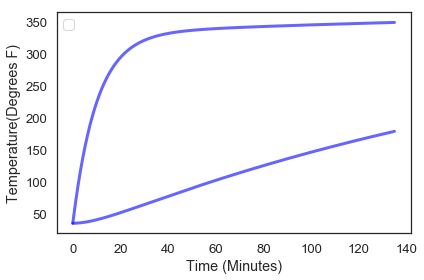

In [52]:
ideal_oven_temp_k = (372-32)*(5/9)+273
system = make_system(params,ideal_oven_temp_k,275,135) #params, T_oven, T_init, t_end
results_ideal, details = run_ode_solver(system,slope_func,max_step=1)
plot_results(results_ideal.T_inner, results_ideal.T_outer, 'blue')

## Interpretation

According to our model, the ideal oven temperature is 372 degrees F and the ideal time cooked is 2 hours and 15 minutes (135mins). The inner temperature was as close to 180 degrees fahrenheit as possible (to match food safety specifications and recipe suggestions) and the outer temperature was 350 degrees fahrenheit,  chosen to be just under the burning temperature (355) to attain the maximum crispy-ness. Our inner temperature and oven temperature matchs recipes roughly but the cooking time was much faster than recipes. The recipe we referenced had a 15 pound turkey in an oven at 350 degrees fahrenheit for 3 hours and 20 mins for an internal temperature of 180 degrees. This difference could show that the cooking time for turkeys is longer than needed, or could be because of miscalculations in r values (discussed below) and simplifications in the laws of heat transfer. Our model does show the reasoning behind the ideal oven temperature and ideal time cooked, and gives a range of values to be considered when cooking the best turkey. 

We made some reasonable assumptions: for example, the turkey was 15 lbs and was thawed (with an assumed fridge temperature of 36 degrees fahrenheit), as opposed to frozen. According to online recipes, these are standard characteristics of a thanksgiving turkey. The outer layer was assumed to be 2 cm, which represents the skin and the very outer layer of flesh, but might not be perfectly descriptive of reality. A problematic assumption we made was that the ideal temperature of the outer layer is just below its burning temperature, which may not be accurate. And to simplify the model, we had to assume that a turkey is “done” when it reaches a certain temperature, instead of taking into account the amount of time the turkey spends at a certain temperature.

Another flaw in our model is the fact that the thermal resistivity of the inner and outer layers were estimated through curve fitting instead of calculated from real data like our thermal mass values were. We attempted to calculate the thermal resistivities off real thermal conductivity values, but the results of the calculation made little sense when used to run the simulation.

There are many different recipes out on the internet that give conflicting information or come from unverified sources, complicating the search for a good turkey cooking recipe. If our model was fine tuned and determined to accurately model heat transfer, it could be used to make a reliable and good recipe without cooking multiple turkeys (a long and expensive process) and give more grounding for the recipe’s accuracy.
